In [67]:
import rospy
import rosbag
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [36]:
path = "/media/devansh/T7/bags_for_devansh"
save_path = "/home/devansh/csvs"
bag_extension = ".bag"
debug = False

In [37]:
def get_bag_names(bag_path):
    """Get bag names from directory
    Args:
        bag_path (str): path where bag files are stored
    Returns:
        bag_names (List[str]): list of bag names in bag_path
    """
    bag_names = []
    for file in os.listdir(bag_path):
        if file.endswith(bag_extension):
            bag_names.append(file)
    return bag_names

In [38]:

def get_data_from_bag(bag_name, bag_path):
    """Open bag, read data and return as lists
    Args:
        bag_name (str): name of bag
        bag_path (str): path of bag
    Returns:
        pressure_data (List[float]): list of time, pressure data
    """    

    # open bag and handle unindexed bag exception
    try:
        bag = rosbag.Bag(os.path.join(bag_path, bag_name))
    except rosbag.bag.ROSBagUnindexedException:
        print(f'{bag_name} is unindexed. Index bag using \'rosbag index <bag_name>\'.')
        print('Exiting...')
        exit(0)
        
    topics = bag.get_type_and_topic_info()[1].keys()
    if debug:
        print(topics)

    topic_name = "/dji_sdk/gps_position"
    # check if topic is in bag
    if "/uav1/dji_sdk/gps_position" in topics:
        topic_name = "/uav1/dji_sdk/gps_position"
    elif "/dji_sdk/gps_position" in topics:
        topic_name = "/dji_sdk/gps_position"
    else:
        print("Topic not found in bag")
        print("Skipping bag")
        return None
    
    if debug:
        print(topic_name)
    
    # height = []
    # create empty numpy array to store height
    height = np.empty((0,2))
    
    for topic, msg, t in bag.read_messages(topic_name):

        # height.append([msg.header.stamp.secs + msg.header.stamp.nsecs/1e9] + [msg.altitude])
        # append time and height to numpy array
        height = np.append(height, [[msg.header.stamp.secs + msg.header.stamp.nsecs/1e9, msg.altitude]], axis=0)

        if debug:
            print(msg.header.stamp.secs + msg.header.stamp.nsecs/1e9 - time)
            time = msg.header.stamp.secs + msg.header.stamp.nsecs/1e9 
            print(height)
    bag.close()
    return height

In [39]:
# get all folders in path
bag_paths = [os.path.join(path, folder) for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
print(bag_paths)

['/media/devansh/T7/bags_for_devansh/1_rossiter', '/media/devansh/T7/bags_for_devansh/2_confluence', '/media/devansh/T7/bags_for_devansh/3_reade']


In [40]:
# get bag names for all bag paths
bag_names = []  # list of lists
for bag_path in bag_paths:
    bag_names.append(get_bag_names(bag_path))
    # append path to bag name
    bag_names[-1] = [os.path.join(bag_path, bag_name) for bag_name in bag_names[-1]]
print(bag_names)

[['/media/devansh/T7/bags_for_devansh/1_rossiter/2021-11-07_19-20-26_dji_sdk_and_thermal.repaired.bag'], ['/media/devansh/T7/bags_for_devansh/2_confluence/2022-04-27_00-36-10.bag'], ['/media/devansh/T7/bags_for_devansh/3_reade/2022-11-08_14-00-58_dji_sdk_and_thermal.bag']]


In [41]:
# loop through all bag names and get height data (2d numpy array), store it into pandas dataframes
dataframes = []
for bag_path, bag_name in zip(bag_paths, bag_names):
    for bag in bag_name:
        # get height data, if None, skip bag
        height = get_data_from_bag(bag, bag_path)
        if height is None:
            continue
        # create dataframe
        df = pd.DataFrame(height, columns=['time', 'height'])
        # append bag name to dataframe
        df['bag_name'] = bag
        # append dataframe to list of dataframes
        dataframes.append(df)

UnboundLocalError: local variable 'topic_name' referenced before assignment

In [52]:
print(dataframes[0].shape)

(7484, 3)


In [54]:
# clean dataframes
for df in dataframes:
    # time starts from 0
    df['time'] = df['time'] - df['time'].iloc[0]
    # height starts from 0
    df['height'] = df['height'] - df['height'].iloc[0]

print(dataframes[0].head())

       time    height                                           bag_name
0  0.000000  0.000000  /media/devansh/T7/bags_for_devansh/1_rossiter/...
1  0.001790  0.010895  /media/devansh/T7/bags_for_devansh/1_rossiter/...
2  0.049179  0.021698  /media/devansh/T7/bags_for_devansh/1_rossiter/...
3  0.049603  0.033447  /media/devansh/T7/bags_for_devansh/1_rossiter/...
4  0.050223  0.045502  /media/devansh/T7/bags_for_devansh/1_rossiter/...


In [62]:
# save dataframes to csv in given folder but save folder structure. Do not include bag_name in csv
for df in dataframes:
    # get bag name
    bag_name = df['bag_name'].iloc[0]
    # get bag path
    bag_path = bag_name.split(bag_name.split('/')[-1])[0]
    # remove bag name from dataframe
    df = df.drop('bag_name', axis=1)
    # get folder name
    folder_name = bag_path.split('/')[-2]
    # create folder if it does not exist
    if not os.path.exists(os.path.join(save_path, folder_name)):
        os.makedirs(os.path.join(save_path, folder_name))
    # save dataframe to csv
    df.to_csv(os.path.join(save_path, folder_name, bag_name.split('/')[-1].split('.')[0] + '.csv'), index=False)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


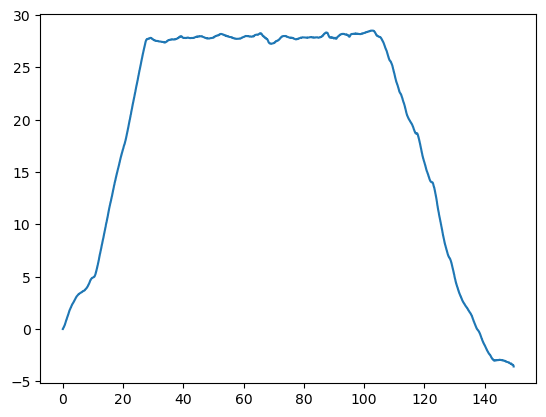

In [65]:
# plots
for df in dataframes:
    plt.plot(df['time'], df['height'])
    
plt.show()